File: barbara.pgm | Width: 512, Height: 512, Max Gray: 255


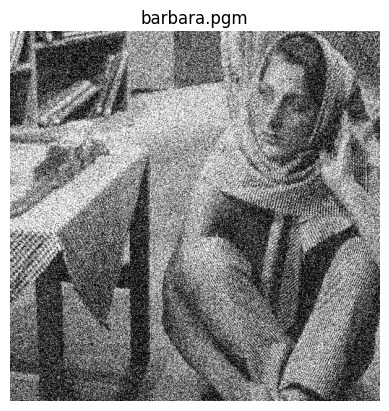

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

def imread(file_path):
    """
    Reads a PGM image file (non-standard format with P5 width height max_gray on one line).

    Args:
        file_path (str): Path to the .pgm file.

    Returns:
        np.ndarray: The image as a NumPy array.
    """
    try:
        with open(file_path, 'rb') as f:
            # Read the first line, which includes P5 and dimensions
            first_line = f.readline().strip().decode(errors='replace')
            if not first_line.startswith("P5"):
                raise ValueError(f"Unsupported format: {first_line}")

            # Extract dimensions and max_gray value from the first line
            parts = first_line.split()
            if len(parts) != 4:
                raise ValueError("Invalid PGM header format.")

            # Parse width, height, and max_gray
            width = int(parts[1])
            height = int(parts[2])
            max_gray = int(parts[3])
            print(f"File: {os.path.basename(file_path)} | Width: {width}, Height: {height}, Max Gray: {max_gray}")

            if max_gray > 255:
                raise ValueError("Only 8-bit PGM files are supported.")

            # Read pixel data
            pixel_data = np.fromfile(f, dtype=np.uint8)
            expected_size = width * height
            actual_size = len(pixel_data)

            if actual_size != expected_size:
                raise ValueError(
                    f"Pixel data size mismatch for {os.path.basename(file_path)}: Expected {expected_size}, got {actual_size}."
                )

            # Reshape into 2D array
            image = pixel_data.reshape((height, width))
            return image
    except Exception as e:
        print(f"Error reading {os.path.basename(file_path)}: {e}")
        return None



# new version of imread
def imread(file_path):
    """
    Reads a PGM image file (non-standard format with P5 width height max_gray on one line).

    Args:
        file_path (str): Path to the .pgm file.

    Returns:
        np.ndarray: The image as a NumPy array.
    """
    try:
        with open(file_path, 'rb') as f:
            # Read the first line and validate the format
            first_line = f.readline().strip().decode(errors='replace')
            if not first_line.startswith("P5"):
                raise ValueError(f"Unsupported format: {first_line}")

            # Handle the non-standard single-line format like 'P5 width height max_gray'
            parts = first_line.split()
            if len(parts) == 4:  # Format is 'P5 width height max_gray'
                _, width, height, max_gray = parts
            else:
                # Otherwise, parse header as multiple lines
                line = f.readline().strip()
                while line.startswith(b'#'):
                    line = f.readline().strip()

                width, height = map(int, line.decode(errors='replace').split())
                max_gray = int(f.readline().strip().decode(errors='replace'))

            # Convert dimensions and max_gray to integers
            width, height, max_gray = int(width), int(height), int(max_gray)

            print(f"File: {os.path.basename(file_path)} | Width: {width}, Height: {height}, Max Gray: {max_gray}")

            if max_gray > 255:
                raise ValueError("Only 8-bit PGM files are supported.")

            # Read pixel data
            pixel_data = np.frombuffer(f.read(), dtype=np.uint8)

            # Ensure the size of pixel data matches the dimensions
            expected_size = width * height
            actual_size = len(pixel_data)

            if actual_size != expected_size:
                raise ValueError(
                    f"Pixel data size mismatch for {os.path.basename(file_path)}: Expected {expected_size}, got {actual_size}."
                )

            # Reshape the pixel data into a 2D array
            image = pixel_data.reshape((height, width))

            return image

    except Exception as e:
        print(f"Error reading {os.path.basename(file_path)}: {e}")
        return None

def show_image(image, title):
    """
    Displays a PGM image using matplotlib.

    Args:
        image (np.ndarray): The image array.
        title (str): Title of the image.
    """
    plt.imshow(image, cmap='gray', vmin=0, vmax=255)
    plt.title(title)
    plt.axis('off')
    plt.show()

def process_single_image():
    """
    Process and display a single PGM image by prompting the user for the file path.
    """
    file_path = input("Enter the path to the PGM image: ").strip()
    image = imread(file_path)
    if image is not None:
        show_image(image, title=os.path.basename(file_path))

# Example usage for Task 1
if __name__ == "__main__":
    process_single_image()


File: barbara.pgm | Width: 512, Height: 512, Max Gray: 255
Reconstruction MSE: 0.000000


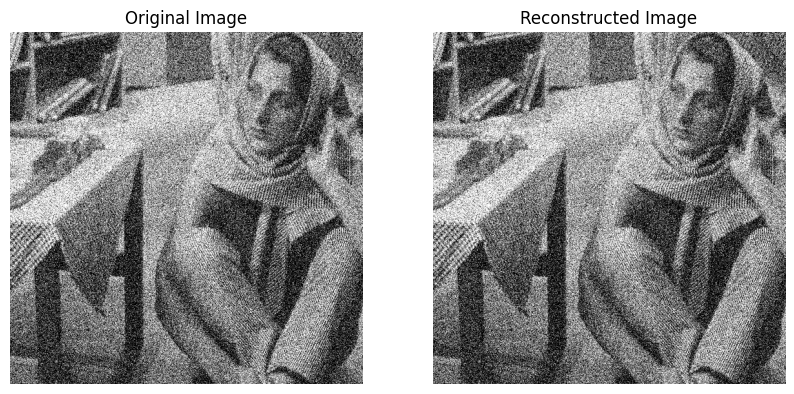

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def ensure_even_dimensions(image):
    """
    Ensure the image dimensions are even by padding if necessary.

    Args:
        image (np.ndarray): Input image.

    Returns:
        np.ndarray: Padded image with even dimensions.
        tuple: Original shape of the image.
    """
    rows, cols = image.shape
    padded_rows = rows + (rows % 2)
    padded_cols = cols + (cols % 2)

    padded_image = np.zeros((padded_rows, padded_cols), dtype=image.dtype)
    padded_image[:rows, :cols] = image

    return padded_image, (rows, cols)

def restore_original_dimensions(image, original_shape):
    """
    Restore the image to its original dimensions by cropping.

    Args:
        image (np.ndarray): Padded image.
        original_shape (tuple): Original shape of the image.

    Returns:
        np.ndarray: Cropped image.
    """
    rows, cols = original_shape
    return image[:rows, :cols]

def haar_transform_single_level(image):
    """
    Perform a single-level Haar wavelet decomposition.

    Args:
        image (np.ndarray): Input 2D image array.

    Returns:
        tuple: (A, H, V, D) representing wavelet coefficients.
    """
    rows, cols = image.shape
    half_rows, half_cols = rows // 2, cols // 2

    A = np.zeros((half_rows, half_cols))
    H = np.zeros((half_rows, half_cols))
    V = np.zeros((half_rows, half_cols))
    D = np.zeros((half_rows, half_cols))

    temp_low = (image[:, ::2] + image[:, 1::2]) / np.sqrt(2)
    temp_high = (image[:, ::2] - image[:, 1::2]) / np.sqrt(2)

    A = (temp_low[::2, :] + temp_low[1::2, :]) / np.sqrt(2)
    V = (temp_low[::2, :] - temp_low[1::2, :]) / np.sqrt(2)
    H = (temp_high[::2, :] + temp_high[1::2, :]) / np.sqrt(2)
    D = (temp_high[::2, :] - temp_high[1::2, :]) / np.sqrt(2)

    return A, H, V, D

def inverse_haar_transform_single_level(A, H, V, D):
    """
    Perform a single-level Haar wavelet reconstruction.

    Args:
        A, H, V, D (np.ndarray): Wavelet coefficients.

    Returns:
        np.ndarray: Reconstructed 2D image array.
    """
    half_rows, half_cols = A.shape

    temp_low = np.zeros((half_rows * 2, half_cols))
    temp_high = np.zeros((half_rows * 2, half_cols))

    temp_low[::2, :] = (A + V) / np.sqrt(2)
    temp_low[1::2, :] = (A - V) / np.sqrt(2)
    temp_high[::2, :] = (H + D) / np.sqrt(2)
    temp_high[1::2, :] = (H - D) / np.sqrt(2)

    reconstructed = np.zeros((half_rows * 2, half_cols * 2))
    reconstructed[:, ::2] = (temp_low + temp_high) / np.sqrt(2)
    reconstructed[:, 1::2] = (temp_low - temp_high) / np.sqrt(2)

    return reconstructed

def fdwt(image, levels=3):
    """
    Perform multi-level Haar wavelet decomposition.

    Args:
        image (np.ndarray): Input 2D image.
        levels (int): Number of levels.

    Returns:
        list: List of coefficients.
    """
    coefficients = []
    current = image.astype(float)

    for _ in range(levels):
        padded, _ = ensure_even_dimensions(current)
        A, H, V, D = haar_transform_single_level(padded)
        coefficients.append((A, H, V, D))
        current = A

    return coefficients

def idwt(coefficients):
    """
    Perform multi-level Haar wavelet reconstruction.

    Args:
        coefficients (list): Wavelet coefficients.

    Returns:
        np.ndarray: Reconstructed image.
    """
    current = coefficients[-1][0]
    for A, H, V, D in reversed(coefficients):
        current = inverse_haar_transform_single_level(A, H, V, D)
    return current

def validate_reconstruction(image, levels=3):
    """
    Validate reconstruction using Haar wavelets and compute MSE.

    Args:
        image (np.ndarray): Input image.
        levels (int): Number of levels.

    Returns:
        tuple: (MSE, reconstructed image).
    """
    padded, original_shape = ensure_even_dimensions(image)
    coefficients = fdwt(padded, levels)
    reconstructed_padded = idwt(coefficients)
    reconstructed = restore_original_dimensions(reconstructed_padded, original_shape)
    mse = np.mean((image - reconstructed) ** 2)
    return mse, reconstructed

def process_task2():
    """
    Process a single image for Haar wavelet validation and reconstruction.
    """
    image_path = input("Enter the path to the PGM image: ").strip()
    image = imread(image_path)
    if image is not None:
        mse, reconstructed_image = validate_reconstruction(image)

        print(f"Reconstruction MSE: {mse:.6f}")

        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.title("Original Image")
        plt.imshow(image, cmap='gray', vmin=0, vmax=255)
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.title("Reconstructed Image")
        plt.imshow(reconstructed_image, cmap='gray', vmin=0, vmax=255)
        plt.axis('off')

        plt.show()

# Example usage for Task 2
if __name__ == "__main__":
    process_task2()


File: barbara.pgm | Width: 512, Height: 512, Max Gray: 255
File: barbara.pgm | Width: 512, Height: 512, Max Gray: 255


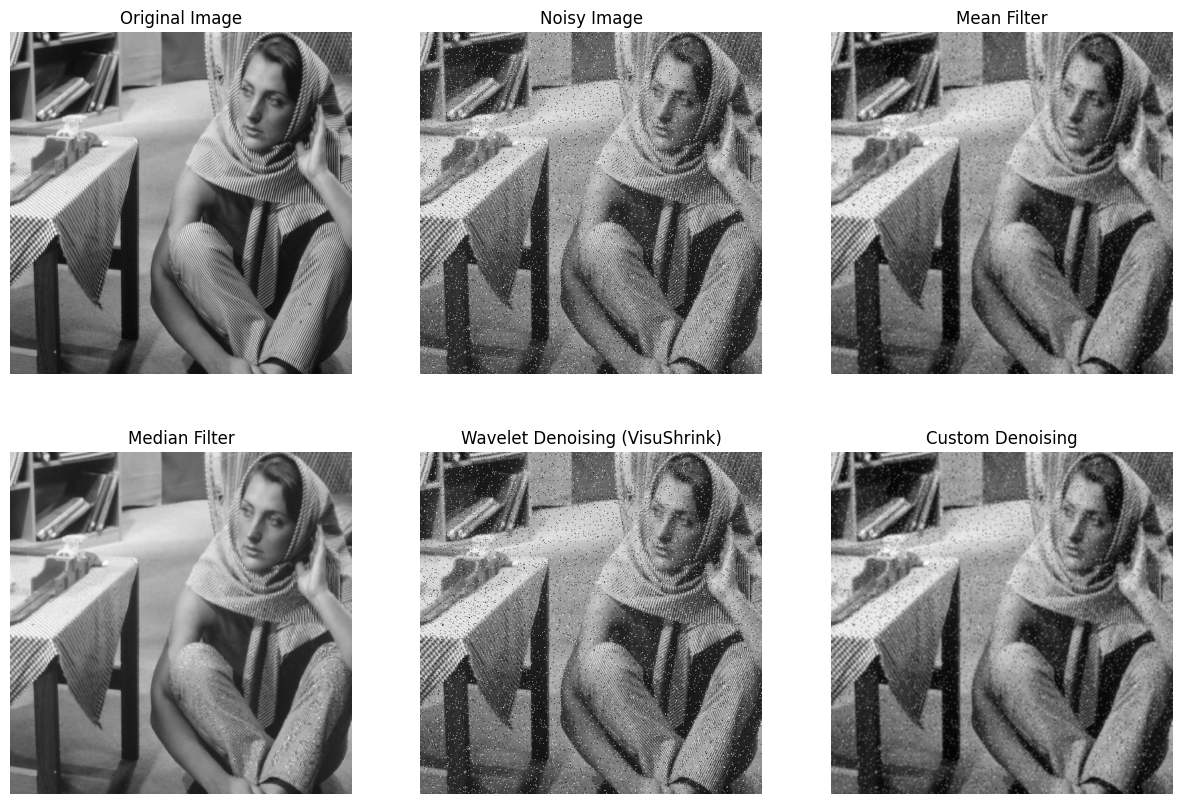

Denoising Results:
  Mean Filter: MSE=59.626537, SSIM=0.547387
  Median Filter: MSE=30.919769, SSIM=0.813529
  Wavelet Denoising (VisuShrink): MSE=904.981614, SSIM=0.443271
  Custom Denoising: MSE=310.792655, SSIM=0.543589


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from scipy.ndimage import uniform_filter, median_filter


def ensure_even_dimensions(image):
    """
    Ensure the image dimensions are even by padding if necessary.

    Args:
        image (np.ndarray): Input image.

    Returns:
        np.ndarray: Padded image with even dimensions.
        tuple: Original shape of the image.
    """
    rows, cols = image.shape
    padded_rows = rows + (rows % 2)
    padded_cols = cols + (cols % 2)

    padded_image = np.zeros((padded_rows, padded_cols), dtype=image.dtype)
    padded_image[:rows, :cols] = image

    return padded_image, (rows, cols)

def restore_original_dimensions(image, original_shape):
    """
    Restore the image to its original dimensions by cropping.

    Args:
        image (np.ndarray): Padded image.
        original_shape (tuple): Original shape of the image.

    Returns:
        np.ndarray: Cropped image.
    """
    rows, cols = original_shape
    return image[:rows, :cols]

def haar_transform_single_level(image):
    """
    Perform a single-level Haar wavelet decomposition.

    Args:
        image (np.ndarray): Input 2D image array.

    Returns:
        tuple: (A, H, V, D) representing wavelet coefficients.
    """
    rows, cols = image.shape
    half_rows, half_cols = rows // 2, cols // 2

    A = np.zeros((half_rows, half_cols))
    H = np.zeros((half_rows, half_cols))
    V = np.zeros((half_rows, half_cols))
    D = np.zeros((half_rows, half_cols))

    temp_low = (image[:, ::2] + image[:, 1::2]) / np.sqrt(2)
    temp_high = (image[:, ::2] - image[:, 1::2]) / np.sqrt(2)

    A = (temp_low[::2, :] + temp_low[1::2, :]) / np.sqrt(2)
    V = (temp_low[::2, :] - temp_low[1::2, :]) / np.sqrt(2)
    H = (temp_high[::2, :] + temp_high[1::2, :]) / np.sqrt(2)
    D = (temp_high[::2, :] - temp_high[1::2, :]) / np.sqrt(2)

    return A, H, V, D

def inverse_haar_transform_single_level(A, H, V, D):
    """
    Perform a single-level Haar wavelet reconstruction.

    Args:
        A, H, V, D (np.ndarray): Wavelet coefficients.

    Returns:
        np.ndarray: Reconstructed 2D image array.
    """
    half_rows, half_cols = A.shape

    temp_low = np.zeros((half_rows * 2, half_cols))
    temp_high = np.zeros((half_rows * 2, half_cols))

    temp_low[::2, :] = (A + V) / np.sqrt(2)
    temp_low[1::2, :] = (A - V) / np.sqrt(2)
    temp_high[::2, :] = (H + D) / np.sqrt(2)
    temp_high[1::2, :] = (H - D) / np.sqrt(2)

    reconstructed = np.zeros((half_rows * 2, half_cols * 2))
    reconstructed[:, ::2] = (temp_low + temp_high) / np.sqrt(2)
    reconstructed[:, 1::2] = (temp_low - temp_high) / np.sqrt(2)

    return reconstructed

def fdwt(image, levels=3):
    """
    Perform multi-level Haar wavelet decomposition.

    Args:
        image (np.ndarray): Input 2D image.
        levels (int): Number of levels.

    Returns:
        list: List of coefficients.
    """
    coefficients = []
    current = image.astype(float)

    for _ in range(levels):
        padded, _ = ensure_even_dimensions(current)
        A, H, V, D = haar_transform_single_level(padded)
        coefficients.append((A, H, V, D))
        current = A

    return coefficients

def idwt(coefficients):
    """
    Perform multi-level Haar wavelet reconstruction.

    Args:
        coefficients (list): Wavelet coefficients.

    Returns:
        np.ndarray: Reconstructed image.
    """
    current = coefficients[-1][0]
    for A, H, V, D in reversed(coefficients):
        current = inverse_haar_transform_single_level(A, H, V, D)
    return current

def compute_mse(original, reconstructed):
    """
    Compute Mean Squared Error (MSE) between the original and reconstructed images.

    Args:
        original (np.ndarray): Original image.
        reconstructed (np.ndarray): Reconstructed image.

    Returns:
        float: MSE value.
    """
    return np.mean((original - reconstructed) ** 2)

def denoise_with_wavelet(noisy_image, levels=3):
    coefficients = fdwt(noisy_image, levels)
    # Thresholding (e.g., VisuShrink: universal threshold sqrt(2*log(n)))
    for i in range(len(coefficients)):
        A, H, V, D = coefficients[i]
        threshold = np.sqrt(2 * np.log(H.size))  # Universal threshold
        H = np.sign(H) * np.maximum(np.abs(H) - threshold, 0)
        V = np.sign(V) * np.maximum(np.abs(V) - threshold, 0)
        D = np.sign(D) * np.maximum(np.abs(D) - threshold, 0)
        coefficients[i] = (A, H, V, D)

    return idwt(coefficients)

def custom_denoise(noisy_image):
    """
    Custom-designed denoising algorithm that combines wavelet and mean filtering.
    """
    padded_image, original_shape = ensure_even_dimensions(noisy_image)
    wavelet_denoised = denoise_with_wavelet(padded_image, levels=3)
    mean_filtered = uniform_filter(wavelet_denoised, size=3)
    return restore_original_dimensions(mean_filtered, original_shape)

def compare_denoising_methods(original, noisy):
    # Ensure dimensions are even
    padded_original, original_shape = ensure_even_dimensions(original)
    padded_noisy, noisy_shape = ensure_even_dimensions(noisy)

    # Apply Mean Filter
    mean_filtered = uniform_filter(padded_noisy, size=3)
    mean_filtered = restore_original_dimensions(mean_filtered, original_shape)

    # Apply Median Filter
    median_filtered = median_filter(padded_noisy, size=3)
    median_filtered = restore_original_dimensions(median_filtered, original_shape)

    # Apply Wavelet Denoising (VisuShrink)
    wavelet_denoised = denoise_with_wavelet(padded_noisy, levels=3)
    wavelet_denoised = restore_original_dimensions(wavelet_denoised, original_shape)

    # Apply Custom Denoising
    custom_denoised = custom_denoise(padded_noisy)
    custom_denoised = restore_original_dimensions(custom_denoised, original_shape)

    # Compute metrics for each method
    methods = {
        "Mean Filter": mean_filtered,
        "Median Filter": median_filtered,
        "Wavelet Denoising (VisuShrink)": wavelet_denoised,
        "Custom Denoising": custom_denoised
    }

    results = {}
    for method, denoised_image in methods.items():
        mse_value = compute_mse(original, denoised_image)
        ssim_value = ssim(original, denoised_image, data_range=denoised_image.max() - denoised_image.min())
        results[method] = (mse_value, ssim_value)

    return methods, results

def process_single_image():
    """
    Process a single image for denoising comparison by prompting the user for file paths.
    """
    original_path = input("Enter the path to the original PGM image: ").strip()
    noisy_path = input("Enter the path to the noisy PGM image: ").strip()

    # Load images
    original_image = imread(original_path)
    noisy_image = imread(noisy_path)

    if original_image is None or noisy_image is None:
        print("Failed to load images.")
        return

    # Compare methods
    denoised_images, metrics = compare_denoising_methods(original_image, noisy_image)

    # Display results
    plt.figure(figsize=(15, 10))
    plt.subplot(2, 3, 1)
    plt.title("Original Image")
    plt.imshow(original_image, cmap="gray")
    plt.axis("off")

    plt.subplot(2, 3, 2)
    plt.title("Noisy Image")
    plt.imshow(noisy_image, cmap="gray")
    plt.axis("off")

    for i, (method, denoised_image) in enumerate(denoised_images.items(), start=3):
        plt.subplot(2, 3, i)
        plt.title(method)
        plt.imshow(denoised_image, cmap="gray")
        plt.axis("off")

    plt.show()

    print("Denoising Results:")
    for method, (mse_value, ssim_value) in metrics.items():
        print(f"  {method}: MSE={mse_value:.6f}, SSIM={ssim_value:.6f}")

if __name__ == "__main__":
    process_single_image()
